In [1]:
using Interact, Convex, Gadfly, SCS
set_default_solver(SCSSolver(verbose=0))

SCSSolver({(:verbose,0)})

# Example problem: global connectome models

<img src="http://www.humanconnectomeproject.org/wp-content/uploads/2014/04/White-Matter-Fibers-HCP-Dataset-Full-sideview-150x150.jpg" width = 300>

$$ Aw \approx b $$

* $b$ gives MR signal (flow) observed at each voxel in each direction
* columns of $A$ are possible fibers
* $w$ selects width of each fiber (proportional to flow) 

Often extremely large-scale data:

* $A \in {\bf R}^{m \times n}$, $m = 1000000$, $n=500000$

In [2]:
# generate data
srand(10)
m,n,p = 50,10,.1
A = sprand(m,n,p)
b = randn(m);

we want to find **reasonable** widths for the fibers that **plausibly** produced the data we observed
    
reasonable widths
* nonnegative
* not too big
* not too many fibers

plausible errors
* errors are not large
* errors are gaussian?

In [3]:
widths = Variable(n)
errors = A*widths-b

AbstractExpr with
head: +
size: (50, 1)
sign: NoSign()
vexity: AffineVexity()


## Optimization formulation

$$
\begin{array}{ll}
    \mbox{minimize} & \mathrm{implausibility}(\mathrm{errors}) + \mathrm{unreasonability}(\mathrm{widths})\\
\mbox{subject to} & \mathrm{widths} \geq 0
\end{array}
$$

## Widths should be nonnegative

If we expect Gaussian errors, then maximizing the likelihood of the errors is the same as minimizing $\|\mathrm{errors}\|_2^2$.

We impose our *prior* that the widths are nonnegative.

$$
\begin{array}{ll}
\mbox{minimize} & \|Aw - b\|_2^2 \\
\mbox{subject to} & w \geq 0
\end{array}
$$

optimal value is 41.463672260918656


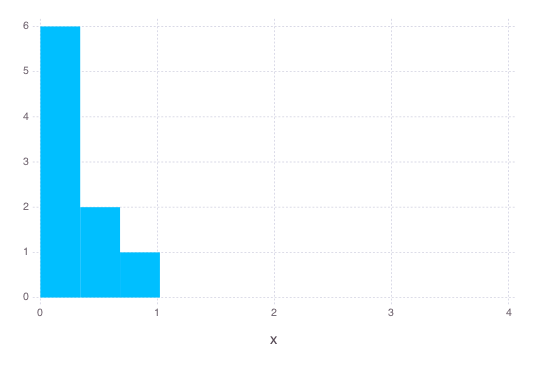

In [4]:
# example data
srand(10)
m,n,p = 50,10,.1
A = sprand(m,n,p)
b = randn(m)

# construct nonnegative least squares problem
widths = Variable(n)
errors = A*widths-b
nnlsq = minimize(sum_squares(errors),
                   widths>=0);

# solve
solve!(nnlsq)
println("optimal value is ", nnlsq.optval)
plot(x=widths.value, Geom.histogram(minbincount = 20), 
         Scale.x_continuous(minvalue=0, maxvalue=3.5), Scale.y_continuous(minvalue=0, maxvalue=6))

In [5]:
# which constraints are active?
round(constraint.dual,2)

LoadError: constraint not defined
while loading In[5], in expression starting on line 2

## Some of these widths are really big

That seems implausible.

What if we add quadratic regularization to encourage small widths? This is sometimes called *ridge regression*.

$$
\begin{array}{ll}
\mbox{minimize} & \|Aw - b\|_2^2 + \gamma\|w\|_2^2 \\
\mbox{subject to} & w \geq 0
\end{array}
$$

Slider{Float64}([Input{Float64}] 1.0,"gamma",1.0,0.0:0.1:2.0)

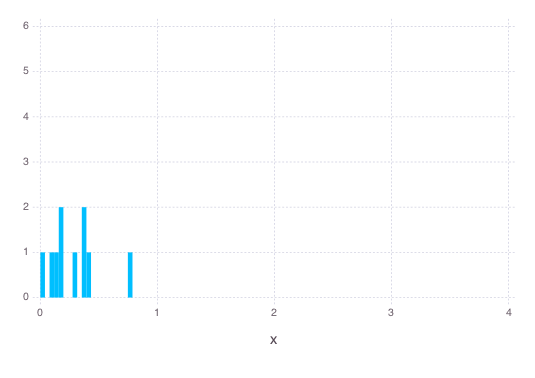

In [6]:
@manipulate for gamma=0:.1:2
    ridge = minimize(sum_squares(errors) + gamma*norm(widths, 2),
                   widths >= 0);

# solve
solve!(ridge)
plot(x=widths.value, Geom.histogram(minbincount = 20), 
         Scale.x_continuous(minvalue=0, maxvalue=3.5), Scale.y_continuous(minvalue=0, maxvalue=6))
end

## Almost all of these widths are nonzero

That seems implausible.

What if we use $p$-norm regularization? For some $p$, can we encourage zero widths?

$$
\begin{array}{ll}
\mbox{minimize} & \|Aw - b\|_2^2 + \gamma\|w\|_p \\
\mbox{subject to} & w \geq 0
\end{array}
$$

$p=1$ is sometimes called the *Lasso* problem.

Slider{Float64}([Input{Float64}] 1.5,"p",1.5,1.0:0.1:2.0)

Slider{Float64}([Input{Float64}] 1.0,"gamma",1.0,0.0:0.1:2.0)

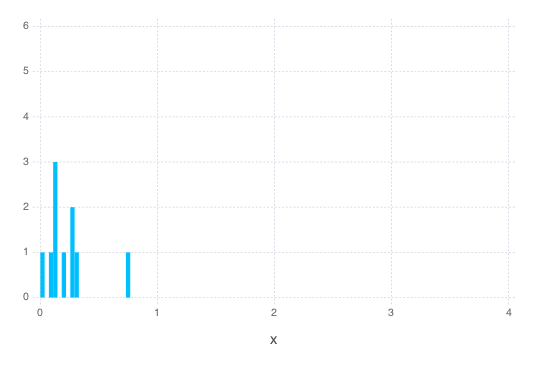

In [7]:
@manipulate for p=1:.1:2, gamma=0:.1:2
lasso = minimize(sum_squares(errors) + gamma*norm(widths, p),
                   widths >= 0);

# solve
solve!(lasso)
plot(x=widths.value, Geom.histogram(minbincount = 20), 
         Scale.x_continuous(minvalue=0, maxvalue=3.5), Scale.y_continuous(minvalue=0, maxvalue=6))
end

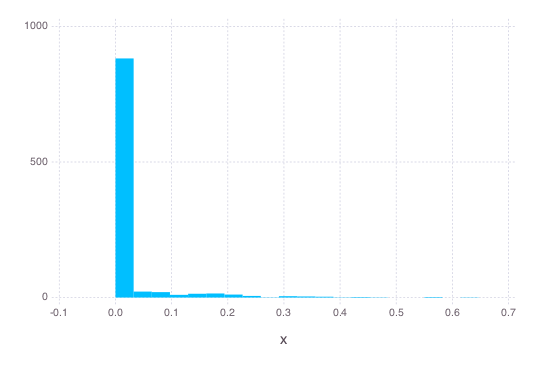

In [8]:
## Now for a bigger version

# example data
srand(1)
m,n,s = 5000,1000,.01
A = sprand(m,n,s)
b = randn(m)

# construct lasso nonnegative least squares problem
widths = Variable(n)
errors = A*widths-b
p_lasso = minimize(sum_squares(errors) + norm(widths, 1),
                   widths >= 0);

# solve
solve!(p_lasso)
round(widths.value,2)
plot(x=widths.value, Geom.histogram(bincount = 20))